In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import wandb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

# Initialize wandb
wandb.init(project="model-a-classifier", config={
    "img_width": 128,
    "img_height": 128,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "architecture": "VGG16",
})


# Configuration
config = wandb.config
data_dir = r'./Data/train'
test_dir = r'./Data/test1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dnicho26 (dnicho26-university-of-north-carolina-at-charlotte). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.5


wandb: Run data is saved locally in /opt/notebooks/Applied-AI-Midterm/wandb/run-20241026_232909-2mn25233
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run robust-shape-9


wandb: ⭐️ View project at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier


wandb: 🚀 View run at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier/runs/2mn25233


True
Tesla P100-PCIE-16GB


In [2]:
# Custom Dataset to handle your directory structure
class CustomImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        
        label = 0 if 'cat' in img_path else 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
from torch.utils.data import DataLoader

# Gathering all image paths
all_images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
train_size = int(0.8 * len(all_images))
valid_size = len(all_images) - train_size

# Splitting the dataset into training and validation sets
train_images, valid_images = torch.utils.data.random_split(all_images, [train_size, valid_size])

# Data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),  # Resize to match input size
        transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
        transforms.RandomRotation(15),  # Limit rotation to 15 degrees for more realistic augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply color jitter for brightness, contrast, saturation, and hue variations
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization based on ImageNet stats
    ]),
    'valid': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Creating datasets
train_dataset = CustomImageDataset(train_images, transform=data_transforms['train'])
valid_dataset = CustomImageDataset(valid_images, transform=data_transforms['valid'])

# Creating data loaders with num_workers and pin_memory for optimized performance
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size, 
    shuffle=True, 
    num_workers=4,  # Adjust based on your system; typically 4-8 works well
    pin_memory=True  # Useful when using GPU for training
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    num_workers=4,  # Adjust based on your system
    pin_memory=True
)

In [4]:
# Fetching a single batch to display image shapes
def display_batch_shapes(loader, loader_name):
    for images, labels in loader:
        print(f"{loader_name} batch shape: {images.shape}")
        break  # Only process the first batch to display shape

display_batch_shapes(train_loader, "Train")
display_batch_shapes(valid_loader, "Validation")


Train batch shape: torch.Size([32, 3, 128, 128])


Validation batch shape: torch.Size([32, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8823529214859009].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039215669393539376..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8509804335832596].


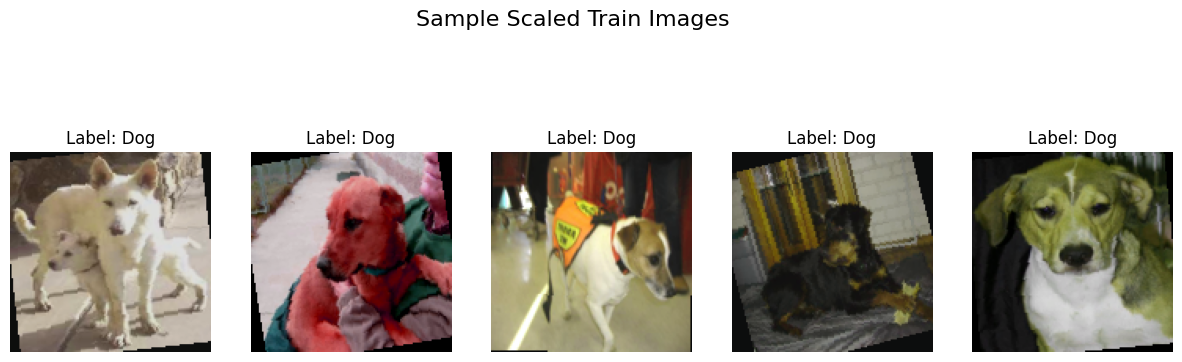

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07058824157714844..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.051757813121725e-08..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01960783576965336..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784314727783203..1.0000000236034394].


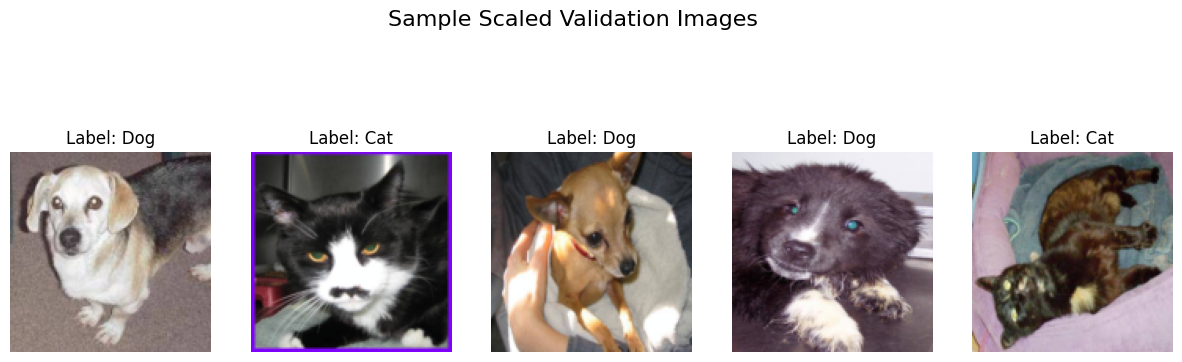

In [5]:
import matplotlib.pyplot as plt

def show_images_from_loader(loader, title):
    # Fetch a batch of images
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axs):
        ax.imshow(images[i] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        ax.set_title(f'Label: {"Cat" if labels[i] == 0 else "Dog"}')
        ax.axis('off')

    plt.show()

# Display some train images
show_images_from_loader(train_loader, "Sample Scaled Train Images")

# Display some validation images
show_images_from_loader(valid_loader, "Sample Scaled Validation Images")

In [6]:
# Load pretrained VGG16 model
from torchvision.models import VGG16_Weights

weights = VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights)
model.classifier[6] = nn.Linear(4096, 2)  # Modify the output layer to match the number of classes
# Freeze layers except the last few
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Define loss function and optimizer
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=[0 if 'cat' in img else 1 for img in all_images])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [7]:
import os

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_val_loss = float('inf')

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.best_val_loss = val_loss


In [8]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, patience=5, model_path='best_model.pth'):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print("Starting training loop...")
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Wrap train_loader with tqdm for progress visualization
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Log training metrics to wandb
        wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_accuracy": epoch_acc})
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        # Wrap valid_loader with tqdm for progress visualization
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", unit="batch"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
    
        # Log validation metrics to wandb
        wandb.log({"epoch": epoch, "val_loss": val_loss, "val_accuracy": val_acc})

        print(f'Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Early stopping
        early_stopping(val_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [9]:
# Train the model
train_model(model, criterion, optimizer, train_loader, valid_loader, config.epochs, patience=10, model_path='./models/best-model-a.pth')

# Finish the wandb run
wandb.finish()

Starting training loop...


Epoch 1/100:   0%|                                                                                                           | 0/625 [00:00<?, ?batch/s]

Epoch 1/100:   0%|▏                                                                                                  | 1/625 [00:01<10:38,  1.02s/batch]

Epoch 1/100:   0%|▍                                                                                                  | 3/625 [00:01<03:22,  3.07batch/s]

Epoch 1/100:   1%|▊                                                                                                  | 5/625 [00:01<01:54,  5.40batch/s]

Epoch 1/100:   1%|█                                                                                                  | 7/625 [00:01<01:19,  7.80batch/s]

Epoch 1/100:   1%|█▍                                                                                                 | 9/625 [00:01<01:00, 10.13batch/s]

Epoch 1/100:   2%|█▋                                                                                                | 11/625 [00:01<00:50, 12.24batch/s]

Epoch 1/100:   2%|██                                                                                                | 13/625 [00:01<00:44, 13.89batch/s]

Epoch 1/100:   2%|██▎                                                                                               | 15/625 [00:01<00:40, 15.19batch/s]

Epoch 1/100:   3%|██▋                                                                                               | 17/625 [00:01<00:37, 16.36batch/s]

Epoch 1/100:   3%|██▉                                                                                               | 19/625 [00:02<00:35, 17.08batch/s]

Epoch 1/100:   3%|███▎                                                                                              | 21/625 [00:02<00:38, 15.53batch/s]

Epoch 1/100:   4%|███▌                                                                                              | 23/625 [00:02<00:44, 13.59batch/s]

Epoch 1/100:   4%|███▉                                                                                              | 25/625 [00:02<00:45, 13.09batch/s]

Epoch 1/100:   4%|████▏                                                                                             | 27/625 [00:02<00:46, 12.77batch/s]

Epoch 1/100:   5%|████▌                                                                                             | 29/625 [00:02<00:47, 12.68batch/s]

Epoch 1/100:   5%|████▊                                                                                             | 31/625 [00:03<00:47, 12.45batch/s]

Epoch 1/100:   5%|█████▏                                                                                            | 33/625 [00:03<00:51, 11.54batch/s]

Epoch 1/100:   6%|█████▍                                                                                            | 35/625 [00:03<00:48, 12.05batch/s]

Epoch 1/100:   6%|█████▊                                                                                            | 37/625 [00:03<00:44, 13.28batch/s]

Epoch 1/100:   6%|██████                                                                                            | 39/625 [00:03<00:47, 12.22batch/s]

Epoch 1/100:   7%|██████▍                                                                                           | 41/625 [00:03<00:43, 13.53batch/s]

Epoch 1/100:   7%|██████▋                                                                                           | 43/625 [00:03<00:40, 14.21batch/s]

Epoch 1/100:   7%|███████                                                                                           | 45/625 [00:04<00:38, 15.04batch/s]

Epoch 1/100:   8%|███████▎                                                                                          | 47/625 [00:04<00:36, 15.81batch/s]

Epoch 1/100:   8%|███████▋                                                                                          | 49/625 [00:04<00:35, 16.36batch/s]

Epoch 1/100:   8%|███████▉                                                                                          | 51/625 [00:04<00:34, 16.54batch/s]

Epoch 1/100:   8%|████████▎                                                                                         | 53/625 [00:04<00:33, 16.84batch/s]

Epoch 1/100:   9%|████████▌                                                                                         | 55/625 [00:04<00:33, 17.18batch/s]

Epoch 1/100:   9%|████████▉                                                                                         | 57/625 [00:04<00:36, 15.69batch/s]

Epoch 1/100:   9%|█████████▎                                                                                        | 59/625 [00:04<00:34, 16.26batch/s]

Epoch 1/100:  10%|█████████▌                                                                                        | 61/625 [00:05<00:40, 13.91batch/s]

Epoch 1/100:  10%|█████████▉                                                                                        | 63/625 [00:05<00:38, 14.79batch/s]

Epoch 1/100:  10%|██████████▏                                                                                       | 65/625 [00:05<00:39, 14.15batch/s]

Epoch 1/100:  11%|██████████▌                                                                                       | 67/625 [00:05<00:36, 15.14batch/s]

Epoch 1/100:  11%|██████████▊                                                                                       | 69/625 [00:05<00:42, 12.94batch/s]

Epoch 1/100:  11%|███████████▏                                                                                      | 71/625 [00:05<00:39, 14.05batch/s]

Epoch 1/100:  12%|███████████▍                                                                                      | 73/625 [00:05<00:40, 13.69batch/s]

Epoch 1/100:  12%|███████████▊                                                                                      | 75/625 [00:06<00:37, 14.75batch/s]

Epoch 1/100:  12%|████████████                                                                                      | 77/625 [00:06<00:39, 13.89batch/s]

Epoch 1/100:  13%|████████████▍                                                                                     | 79/625 [00:06<00:43, 12.49batch/s]

Epoch 1/100:  13%|████████████▋                                                                                     | 81/625 [00:06<00:46, 11.76batch/s]

Epoch 1/100:  13%|█████████████                                                                                     | 83/625 [00:06<00:43, 12.58batch/s]

Epoch 1/100:  14%|█████████████▎                                                                                    | 85/625 [00:06<00:40, 13.46batch/s]

Epoch 1/100:  14%|█████████████▋                                                                                    | 87/625 [00:06<00:37, 14.52batch/s]

Epoch 1/100:  14%|█████████████▉                                                                                    | 89/625 [00:07<00:34, 15.40batch/s]

Epoch 1/100:  15%|██████████████▎                                                                                   | 91/625 [00:07<00:33, 15.87batch/s]

Epoch 1/100:  15%|██████████████▌                                                                                   | 93/625 [00:07<00:32, 16.30batch/s]

Epoch 1/100:  15%|██████████████▉                                                                                   | 95/625 [00:07<00:31, 16.73batch/s]

Epoch 1/100:  16%|███████████████▏                                                                                  | 97/625 [00:07<00:31, 16.63batch/s]

Epoch 1/100:  16%|███████████████▌                                                                                  | 99/625 [00:07<00:31, 16.68batch/s]

Epoch 1/100:  16%|███████████████▋                                                                                 | 101/625 [00:07<00:33, 15.53batch/s]

Epoch 1/100:  16%|███████████████▉                                                                                 | 103/625 [00:07<00:33, 15.54batch/s]

Epoch 1/100:  17%|████████████████▎                                                                                | 105/625 [00:08<00:34, 15.00batch/s]

Epoch 1/100:  17%|████████████████▌                                                                                | 107/625 [00:08<00:32, 15.89batch/s]

Epoch 1/100:  17%|████████████████▉                                                                                | 109/625 [00:08<00:35, 14.64batch/s]

Epoch 1/100:  18%|█████████████████▏                                                                               | 111/625 [00:08<00:36, 14.26batch/s]

Epoch 1/100:  18%|█████████████████▌                                                                               | 113/625 [00:08<00:36, 13.98batch/s]

Epoch 1/100:  18%|█████████████████▊                                                                               | 115/625 [00:08<00:36, 13.87batch/s]

Epoch 1/100:  19%|██████████████████▏                                                                              | 117/625 [00:08<00:37, 13.71batch/s]

Epoch 1/100:  19%|██████████████████▍                                                                              | 119/625 [00:09<00:40, 12.49batch/s]

Epoch 1/100:  19%|██████████████████▊                                                                              | 121/625 [00:09<00:42, 11.79batch/s]

Epoch 1/100:  20%|███████████████████                                                                              | 123/625 [00:09<00:41, 12.17batch/s]

Epoch 1/100:  20%|███████████████████▍                                                                             | 125/625 [00:09<00:46, 10.82batch/s]

Epoch 1/100:  20%|███████████████████▋                                                                             | 127/625 [00:09<00:47, 10.52batch/s]

Epoch 1/100:  21%|████████████████████                                                                             | 129/625 [00:10<00:45, 10.97batch/s]

Epoch 1/100:  21%|████████████████████▎                                                                            | 131/625 [00:10<00:42, 11.73batch/s]

Epoch 1/100:  21%|████████████████████▋                                                                            | 133/625 [00:10<00:40, 12.20batch/s]

Epoch 1/100:  22%|████████████████████▉                                                                            | 135/625 [00:10<00:39, 12.50batch/s]

Epoch 1/100:  22%|█████████████████████▎                                                                           | 137/625 [00:10<00:38, 12.76batch/s]

Epoch 1/100:  22%|█████████████████████▌                                                                           | 139/625 [00:10<00:37, 12.93batch/s]

Epoch 1/100:  23%|█████████████████████▉                                                                           | 141/625 [00:10<00:36, 13.20batch/s]

Epoch 1/100:  23%|██████████████████████▏                                                                          | 143/625 [00:11<00:36, 13.09batch/s]

Epoch 1/100:  23%|██████████████████████▌                                                                          | 145/625 [00:11<00:36, 13.29batch/s]

Epoch 1/100:  24%|██████████████████████▊                                                                          | 147/625 [00:11<00:35, 13.29batch/s]

Epoch 1/100:  24%|███████████████████████                                                                          | 149/625 [00:11<00:38, 12.41batch/s]

Epoch 1/100:  24%|███████████████████████▍                                                                         | 151/625 [00:11<00:40, 11.76batch/s]

Epoch 1/100:  24%|███████████████████████▋                                                                         | 153/625 [00:11<00:38, 12.21batch/s]

Epoch 1/100:  25%|████████████████████████                                                                         | 155/625 [00:12<00:37, 12.64batch/s]

Epoch 1/100:  25%|████████████████████████▎                                                                        | 157/625 [00:12<00:36, 12.84batch/s]

Epoch 1/100:  25%|████████████████████████▋                                                                        | 159/625 [00:12<00:35, 12.95batch/s]

Epoch 1/100:  26%|████████████████████████▉                                                                        | 161/625 [00:12<00:35, 13.11batch/s]

Epoch 1/100:  26%|█████████████████████████▎                                                                       | 163/625 [00:12<00:42, 10.78batch/s]

Epoch 1/100:  26%|█████████████████████████▌                                                                       | 165/625 [00:12<00:42, 10.76batch/s]

Epoch 1/100:  27%|█████████████████████████▉                                                                       | 167/625 [00:13<00:41, 11.07batch/s]

Epoch 1/100:  27%|██████████████████████████▏                                                                      | 169/625 [00:13<00:38, 11.90batch/s]

Epoch 1/100:  27%|██████████████████████████▌                                                                      | 171/625 [00:13<00:36, 12.29batch/s]

Epoch 1/100:  28%|██████████████████████████▊                                                                      | 173/625 [00:13<00:35, 12.57batch/s]

Epoch 1/100:  28%|███████████████████████████▏                                                                     | 175/625 [00:13<00:36, 12.45batch/s]

Epoch 1/100:  28%|███████████████████████████▍                                                                     | 177/625 [00:13<00:39, 11.20batch/s]

Epoch 1/100:  29%|███████████████████████████▊                                                                     | 179/625 [00:14<00:37, 11.85batch/s]

Epoch 1/100:  29%|████████████████████████████                                                                     | 181/625 [00:14<00:36, 12.23batch/s]

Epoch 1/100:  29%|████████████████████████████▍                                                                    | 183/625 [00:14<00:35, 12.58batch/s]

Epoch 1/100:  30%|████████████████████████████▋                                                                    | 185/625 [00:14<00:34, 12.79batch/s]

Epoch 1/100:  30%|█████████████████████████████                                                                    | 187/625 [00:14<00:34, 12.88batch/s]

Epoch 1/100:  30%|█████████████████████████████▎                                                                   | 189/625 [00:14<00:33, 13.06batch/s]

Epoch 1/100:  31%|█████████████████████████████▋                                                                   | 191/625 [00:15<00:33, 13.09batch/s]

Epoch 1/100:  31%|█████████████████████████████▉                                                                   | 193/625 [00:15<00:32, 13.16batch/s]

Epoch 1/100:  31%|██████████████████████████████▎                                                                  | 195/625 [00:15<00:32, 13.20batch/s]

Epoch 1/100:  32%|██████████████████████████████▌                                                                  | 197/625 [00:15<00:32, 13.24batch/s]

Epoch 1/100:  32%|██████████████████████████████▉                                                                  | 199/625 [00:15<00:32, 13.13batch/s]

Epoch 1/100:  32%|███████████████████████████████▏                                                                 | 201/625 [00:15<00:32, 13.11batch/s]

Epoch 1/100:  32%|███████████████████████████████▌                                                                 | 203/625 [00:15<00:35, 11.94batch/s]

Epoch 1/100:  33%|███████████████████████████████▊                                                                 | 205/625 [00:16<00:39, 10.71batch/s]

Epoch 1/100:  33%|████████████████████████████████▏                                                                | 207/625 [00:16<00:42,  9.77batch/s]

Epoch 1/100:  33%|████████████████████████████████▍                                                                | 209/625 [00:16<00:40, 10.24batch/s]

Epoch 1/100:  34%|████████████████████████████████▋                                                                | 211/625 [00:16<00:37, 11.09batch/s]

Epoch 1/100:  34%|█████████████████████████████████                                                                | 213/625 [00:16<00:35, 11.73batch/s]

Epoch 1/100:  34%|█████████████████████████████████▎                                                               | 215/625 [00:17<00:34, 12.02batch/s]

Epoch 1/100:  35%|█████████████████████████████████▋                                                               | 217/625 [00:17<00:33, 12.34batch/s]

Epoch 1/100:  35%|█████████████████████████████████▉                                                               | 219/625 [00:17<00:31, 12.75batch/s]

Epoch 1/100:  35%|██████████████████████████████████▎                                                              | 221/625 [00:17<00:31, 12.87batch/s]

Epoch 1/100:  36%|██████████████████████████████████▌                                                              | 223/625 [00:17<00:30, 13.12batch/s]

Epoch 1/100:  36%|██████████████████████████████████▉                                                              | 225/625 [00:17<00:30, 13.16batch/s]

Epoch 1/100:  36%|███████████████████████████████████▏                                                             | 227/625 [00:17<00:29, 13.30batch/s]

Epoch 1/100:  37%|███████████████████████████████████▌                                                             | 229/625 [00:18<00:29, 13.40batch/s]

Epoch 1/100:  37%|███████████████████████████████████▊                                                             | 231/625 [00:18<00:29, 13.40batch/s]

Epoch 1/100:  37%|████████████████████████████████████▏                                                            | 233/625 [00:18<00:29, 13.39batch/s]

Epoch 1/100:  38%|████████████████████████████████████▍                                                            | 235/625 [00:18<00:29, 13.44batch/s]

Epoch 1/100:  38%|████████████████████████████████████▊                                                            | 237/625 [00:18<00:29, 13.36batch/s]

Epoch 1/100:  38%|█████████████████████████████████████                                                            | 239/625 [00:18<00:28, 13.38batch/s]

Epoch 1/100:  39%|█████████████████████████████████████▍                                                           | 241/625 [00:19<00:30, 12.75batch/s]

Epoch 1/100:  39%|█████████████████████████████████████▋                                                           | 243/625 [00:19<00:39,  9.69batch/s]

Epoch 1/100:  39%|██████████████████████████████████████                                                           | 245/625 [00:19<00:38, 10.00batch/s]

Epoch 1/100:  40%|██████████████████████████████████████▎                                                          | 247/625 [00:19<00:36, 10.45batch/s]

Epoch 1/100:  40%|██████████████████████████████████████▋                                                          | 249/625 [00:19<00:33, 11.23batch/s]

Epoch 1/100:  40%|██████████████████████████████████████▉                                                          | 251/625 [00:20<00:31, 11.77batch/s]

Epoch 1/100:  40%|███████████████████████████████████████▎                                                         | 253/625 [00:20<00:30, 12.19batch/s]

Epoch 1/100:  41%|███████████████████████████████████████▌                                                         | 255/625 [00:20<00:29, 12.62batch/s]

Epoch 1/100:  41%|███████████████████████████████████████▉                                                         | 257/625 [00:20<00:28, 12.72batch/s]

Epoch 1/100:  41%|████████████████████████████████████████▏                                                        | 259/625 [00:20<00:28, 12.89batch/s]

Epoch 1/100:  42%|████████████████████████████████████████▌                                                        | 261/625 [00:20<00:28, 12.92batch/s]

Epoch 1/100:  42%|████████████████████████████████████████▊                                                        | 263/625 [00:20<00:27, 13.13batch/s]

Epoch 1/100:  42%|█████████████████████████████████████████▏                                                       | 265/625 [00:21<00:27, 13.22batch/s]

Epoch 1/100:  43%|█████████████████████████████████████████▍                                                       | 267/625 [00:21<00:30, 11.77batch/s]

Epoch 1/100:  43%|█████████████████████████████████████████▋                                                       | 269/625 [00:21<00:30, 11.80batch/s]

Epoch 1/100:  43%|██████████████████████████████████████████                                                       | 271/625 [00:21<00:28, 12.21batch/s]

Epoch 1/100:  44%|██████████████████████████████████████████▎                                                      | 273/625 [00:21<00:28, 12.34batch/s]

Epoch 1/100:  44%|██████████████████████████████████████████▋                                                      | 275/625 [00:21<00:28, 12.39batch/s]

Epoch 1/100:  44%|██████████████████████████████████████████▉                                                      | 277/625 [00:22<00:27, 12.66batch/s]

Epoch 1/100:  45%|███████████████████████████████████████████▎                                                     | 279/625 [00:22<00:26, 12.84batch/s]

Epoch 1/100:  45%|███████████████████████████████████████████▌                                                     | 281/625 [00:22<00:32, 10.53batch/s]

Epoch 1/100:  45%|███████████████████████████████████████████▉                                                     | 283/625 [00:22<00:31, 10.88batch/s]

Epoch 1/100:  46%|████████████████████████████████████████████▏                                                    | 285/625 [00:22<00:30, 11.28batch/s]

Epoch 1/100:  46%|████████████████████████████████████████████▌                                                    | 287/625 [00:22<00:28, 11.82batch/s]

Epoch 1/100:  46%|████████████████████████████████████████████▊                                                    | 289/625 [00:23<00:27, 12.21batch/s]

Epoch 1/100:  47%|█████████████████████████████████████████████▏                                                   | 291/625 [00:23<00:27, 12.36batch/s]

Epoch 1/100:  47%|█████████████████████████████████████████████▍                                                   | 293/625 [00:23<00:29, 11.24batch/s]

Epoch 1/100:  47%|█████████████████████████████████████████████▊                                                   | 295/625 [00:23<00:28, 11.48batch/s]

Epoch 1/100:  48%|██████████████████████████████████████████████                                                   | 297/625 [00:23<00:27, 11.90batch/s]

Epoch 1/100:  48%|██████████████████████████████████████████████▍                                                  | 299/625 [00:23<00:26, 12.26batch/s]

Epoch 1/100:  48%|██████████████████████████████████████████████▋                                                  | 301/625 [00:24<00:25, 12.48batch/s]

Epoch 1/100:  48%|███████████████████████████████████████████████                                                  | 303/625 [00:24<00:25, 12.74batch/s]

Epoch 1/100:  49%|███████████████████████████████████████████████▎                                                 | 305/625 [00:24<00:24, 12.84batch/s]

Epoch 1/100:  49%|███████████████████████████████████████████████▋                                                 | 307/625 [00:24<00:24, 12.84batch/s]

Epoch 1/100:  49%|███████████████████████████████████████████████▉                                                 | 309/625 [00:24<00:24, 12.96batch/s]

Epoch 1/100:  50%|████████████████████████████████████████████████▎                                                | 311/625 [00:24<00:24, 13.07batch/s]

Epoch 1/100:  50%|████████████████████████████████████████████████▌                                                | 313/625 [00:25<00:23, 13.04batch/s]

Epoch 1/100:  50%|████████████████████████████████████████████████▉                                                | 315/625 [00:25<00:23, 13.08batch/s]

Epoch 1/100:  51%|█████████████████████████████████████████████████▏                                               | 317/625 [00:25<00:28, 10.67batch/s]

Epoch 1/100:  51%|█████████████████████████████████████████████████▌                                               | 319/625 [00:25<00:28, 10.79batch/s]

Epoch 1/100:  51%|█████████████████████████████████████████████████▊                                               | 321/625 [00:25<00:30,  9.82batch/s]

Epoch 1/100:  52%|██████████████████████████████████████████████████▏                                              | 323/625 [00:26<00:28, 10.69batch/s]

Epoch 1/100:  52%|██████████████████████████████████████████████████▍                                              | 325/625 [00:26<00:26, 11.30batch/s]

Epoch 1/100:  52%|██████████████████████████████████████████████████▊                                              | 327/625 [00:26<00:25, 11.79batch/s]

Epoch 1/100:  53%|███████████████████████████████████████████████████                                              | 329/625 [00:26<00:24, 12.30batch/s]

Epoch 1/100:  53%|███████████████████████████████████████████████████▎                                             | 331/625 [00:26<00:23, 12.59batch/s]

Epoch 1/100:  53%|███████████████████████████████████████████████████▋                                             | 333/625 [00:26<00:23, 12.69batch/s]

Epoch 1/100:  54%|███████████████████████████████████████████████████▉                                             | 335/625 [00:26<00:22, 12.91batch/s]

Epoch 1/100:  54%|████████████████████████████████████████████████████▎                                            | 337/625 [00:27<00:22, 13.08batch/s]

Epoch 1/100:  54%|████████████████████████████████████████████████████▌                                            | 339/625 [00:27<00:21, 13.13batch/s]

Epoch 1/100:  55%|████████████████████████████████████████████████████▉                                            | 341/625 [00:27<00:21, 12.93batch/s]

Epoch 1/100:  55%|█████████████████████████████████████████████████████▏                                           | 343/625 [00:27<00:21, 13.14batch/s]

Epoch 1/100:  55%|█████████████████████████████████████████████████████▌                                           | 345/625 [00:27<00:21, 13.14batch/s]

Epoch 1/100:  56%|█████████████████████████████████████████████████████▊                                           | 347/625 [00:27<00:21, 13.20batch/s]

Epoch 1/100:  56%|██████████████████████████████████████████████████████▏                                          | 349/625 [00:27<00:20, 13.20batch/s]

Epoch 1/100:  56%|██████████████████████████████████████████████████████▍                                          | 351/625 [00:28<00:20, 13.23batch/s]

Epoch 1/100:  56%|██████████████████████████████████████████████████████▊                                          | 353/625 [00:28<00:20, 13.10batch/s]

Epoch 1/100:  57%|███████████████████████████████████████████████████████                                          | 355/625 [00:28<00:25, 10.50batch/s]

Epoch 1/100:  57%|███████████████████████████████████████████████████████▍                                         | 357/625 [00:28<00:27,  9.88batch/s]

Epoch 1/100:  57%|███████████████████████████████████████████████████████▋                                         | 359/625 [00:28<00:25, 10.27batch/s]

Epoch 1/100:  58%|████████████████████████████████████████████████████████                                         | 361/625 [00:29<00:24, 11.00batch/s]

Epoch 1/100:  58%|████████████████████████████████████████████████████████▎                                        | 363/625 [00:29<00:22, 11.71batch/s]

Epoch 1/100:  58%|████████████████████████████████████████████████████████▋                                        | 365/625 [00:29<00:21, 12.11batch/s]

Epoch 1/100:  59%|████████████████████████████████████████████████████████▉                                        | 367/625 [00:29<00:20, 12.53batch/s]

Epoch 1/100:  59%|█████████████████████████████████████████████████████████▎                                       | 369/625 [00:29<00:19, 12.84batch/s]

Epoch 1/100:  59%|█████████████████████████████████████████████████████████▌                                       | 371/625 [00:29<00:19, 12.95batch/s]

Epoch 1/100:  60%|█████████████████████████████████████████████████████████▉                                       | 373/625 [00:30<00:19, 13.03batch/s]

Epoch 1/100:  60%|██████████████████████████████████████████████████████████▏                                      | 375/625 [00:30<00:19, 13.05batch/s]

Epoch 1/100:  60%|██████████████████████████████████████████████████████████▌                                      | 377/625 [00:30<00:19, 12.92batch/s]

Epoch 1/100:  61%|██████████████████████████████████████████████████████████▊                                      | 379/625 [00:30<00:18, 13.07batch/s]

Epoch 1/100:  61%|███████████████████████████████████████████████████████████▏                                     | 381/625 [00:30<00:18, 13.11batch/s]

Epoch 1/100:  61%|███████████████████████████████████████████████████████████▍                                     | 383/625 [00:30<00:21, 11.11batch/s]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████▊                                     | 385/625 [00:31<00:20, 11.76batch/s]

Epoch 1/100:  62%|████████████████████████████████████████████████████████████                                     | 387/625 [00:31<00:19, 12.09batch/s]

Epoch 1/100:  62%|████████████████████████████████████████████████████████████▎                                    | 389/625 [00:31<00:19, 12.40batch/s]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████▋                                    | 391/625 [00:31<00:20, 11.66batch/s]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████▉                                    | 393/625 [00:31<00:22, 10.48batch/s]

Epoch 1/100:  63%|█████████████████████████████████████████████████████████████▎                                   | 395/625 [00:31<00:20, 11.18batch/s]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████▌                                   | 397/625 [00:32<00:19, 11.89batch/s]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████▉                                   | 399/625 [00:32<00:17, 12.61batch/s]

Epoch 1/100:  64%|██████████████████████████████████████████████████████████████▏                                  | 401/625 [00:32<00:16, 13.21batch/s]

Epoch 1/100:  64%|██████████████████████████████████████████████████████████████▌                                  | 403/625 [00:32<00:16, 13.68batch/s]

Epoch 1/100:  65%|██████████████████████████████████████████████████████████████▊                                  | 405/625 [00:32<00:16, 13.23batch/s]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████▏                                 | 407/625 [00:33<00:26,  8.08batch/s]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████▍                                 | 409/625 [00:33<00:36,  5.96batch/s]

Epoch 1/100:  66%|███████████████████████████████████████████████████████████████▋                                 | 410/625 [00:33<00:33,  6.38batch/s]

Epoch 1/100:  66%|███████████████████████████████████████████████████████████████▊                                 | 411/625 [00:33<00:31,  6.73batch/s]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████                                 | 413/625 [00:34<00:26,  7.90batch/s]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████▍                                | 415/625 [00:34<00:26,  7.95batch/s]

Epoch 1/100:  67%|████████████████████████████████████████████████████████████████▌                                | 416/625 [00:34<00:27,  7.61batch/s]

Epoch 1/100:  67%|████████████████████████████████████████████████████████████████▊                                | 418/625 [00:34<00:24,  8.32batch/s]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████                                | 419/625 [00:34<00:23,  8.58batch/s]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████▎                               | 421/625 [00:34<00:21,  9.52batch/s]

Epoch 1/100:  68%|█████████████████████████████████████████████████████████████████▋                               | 423/625 [00:35<00:19, 10.29batch/s]

Epoch 1/100:  68%|█████████████████████████████████████████████████████████████████▉                               | 425/625 [00:35<00:19, 10.49batch/s]

Epoch 1/100:  68%|██████████████████████████████████████████████████████████████████▎                              | 427/625 [00:35<00:21,  9.26batch/s]

Epoch 1/100:  69%|██████████████████████████████████████████████████████████████████▌                              | 429/625 [00:35<00:19,  9.98batch/s]

Epoch 1/100:  69%|██████████████████████████████████████████████████████████████████▉                              | 431/625 [00:35<00:18, 10.50batch/s]

Epoch 1/100:  69%|███████████████████████████████████████████████████████████████████▏                             | 433/625 [00:36<00:17, 10.98batch/s]

Epoch 1/100:  70%|███████████████████████████████████████████████████████████████████▌                             | 435/625 [00:36<00:16, 11.40batch/s]

Epoch 1/100:  70%|███████████████████████████████████████████████████████████████████▊                             | 437/625 [00:36<00:16, 11.64batch/s]

Epoch 1/100:  70%|████████████████████████████████████████████████████████████████████▏                            | 439/625 [00:36<00:15, 11.68batch/s]

Epoch 1/100:  71%|████████████████████████████████████████████████████████████████████▍                            | 441/625 [00:36<00:15, 11.58batch/s]

Epoch 1/100:  71%|████████████████████████████████████████████████████████████████████▊                            | 443/625 [00:36<00:15, 11.58batch/s]

Epoch 1/100:  71%|█████████████████████████████████████████████████████████████████████                            | 445/625 [00:37<00:15, 11.74batch/s]

Epoch 1/100:  72%|█████████████████████████████████████████████████████████████████████▎                           | 447/625 [00:37<00:14, 11.95batch/s]

Epoch 1/100:  72%|█████████████████████████████████████████████████████████████████████▋                           | 449/625 [00:37<00:15, 11.43batch/s]

Epoch 1/100:  72%|█████████████████████████████████████████████████████████████████████▉                           | 451/625 [00:37<00:18,  9.51batch/s]

Epoch 1/100:  72%|██████████████████████████████████████████████████████████████████████▎                          | 453/625 [00:37<00:19,  8.67batch/s]

Epoch 1/100:  73%|██████████████████████████████████████████████████████████████████████▌                          | 455/625 [00:38<00:17,  9.58batch/s]

Epoch 1/100:  73%|██████████████████████████████████████████████████████████████████████▉                          | 457/625 [00:38<00:16, 10.15batch/s]

Epoch 1/100:  73%|███████████████████████████████████████████████████████████████████████▏                         | 459/625 [00:38<00:15, 10.63batch/s]

Epoch 1/100:  74%|███████████████████████████████████████████████████████████████████████▌                         | 461/625 [00:38<00:14, 11.04batch/s]

Epoch 1/100:  74%|███████████████████████████████████████████████████████████████████████▊                         | 463/625 [00:38<00:14, 11.19batch/s]

Epoch 1/100:  74%|████████████████████████████████████████████████████████████████████████▏                        | 465/625 [00:38<00:13, 11.55batch/s]

Epoch 1/100:  75%|████████████████████████████████████████████████████████████████████████▍                        | 467/625 [00:39<00:13, 11.67batch/s]

Epoch 1/100:  75%|████████████████████████████████████████████████████████████████████████▊                        | 469/625 [00:39<00:13, 11.79batch/s]

Epoch 1/100:  75%|█████████████████████████████████████████████████████████████████████████                        | 471/625 [00:39<00:12, 11.88batch/s]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████▍                       | 473/625 [00:39<00:12, 11.97batch/s]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████▋                       | 475/625 [00:39<00:12, 11.87batch/s]

Epoch 1/100:  76%|██████████████████████████████████████████████████████████████████████████                       | 477/625 [00:39<00:12, 11.98batch/s]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████▎                      | 479/625 [00:40<00:12, 11.83batch/s]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████▋                      | 481/625 [00:40<00:12, 11.95batch/s]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████▉                      | 483/625 [00:40<00:13, 10.22batch/s]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████▎                     | 485/625 [00:40<00:15,  8.90batch/s]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████▍                     | 486/625 [00:40<00:15,  8.94batch/s]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████▋                     | 488/625 [00:41<00:14,  9.68batch/s]

Epoch 1/100:  78%|████████████████████████████████████████████████████████████████████████████                     | 490/625 [00:41<00:13, 10.12batch/s]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████▎                    | 492/625 [00:41<00:12, 10.67batch/s]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████▋                    | 494/625 [00:41<00:12, 10.83batch/s]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████▉                    | 496/625 [00:41<00:11, 11.08batch/s]

Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████▎                   | 498/625 [00:41<00:11, 11.21batch/s]

Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████▌                   | 500/625 [00:42<00:10, 11.47batch/s]

Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████▉                   | 502/625 [00:42<00:10, 11.56batch/s]

Epoch 1/100:  81%|██████████████████████████████████████████████████████████████████████████████▏                  | 504/625 [00:42<00:10, 11.47batch/s]

Epoch 1/100:  81%|██████████████████████████████████████████████████████████████████████████████▌                  | 506/625 [00:42<00:11, 10.00batch/s]

Epoch 1/100:  81%|██████████████████████████████████████████████████████████████████████████████▊                  | 508/625 [00:42<00:11, 10.33batch/s]

Epoch 1/100:  82%|███████████████████████████████████████████████████████████████████████████████▏                 | 510/625 [00:43<00:10, 10.69batch/s]

Epoch 1/100:  82%|███████████████████████████████████████████████████████████████████████████████▍                 | 512/625 [00:43<00:10, 11.09batch/s]

Epoch 1/100:  82%|███████████████████████████████████████████████████████████████████████████████▊                 | 514/625 [00:43<00:09, 11.32batch/s]

Epoch 1/100:  83%|████████████████████████████████████████████████████████████████████████████████                 | 516/625 [00:43<00:09, 11.44batch/s]

Epoch 1/100:  83%|████████████████████████████████████████████████████████████████████████████████▍                | 518/625 [00:43<00:10, 10.11batch/s]

Epoch 1/100:  83%|████████████████████████████████████████████████████████████████████████████████▋                | 520/625 [00:44<00:11,  9.31batch/s]

Epoch 1/100:  84%|█████████████████████████████████████████████████████████████████████████████████                | 522/625 [00:44<00:10,  9.67batch/s]

Epoch 1/100:  84%|█████████████████████████████████████████████████████████████████████████████████▎               | 524/625 [00:44<00:09, 10.25batch/s]

Epoch 1/100:  84%|█████████████████████████████████████████████████████████████████████████████████▋               | 526/625 [00:44<00:10,  9.51batch/s]

Epoch 1/100:  84%|█████████████████████████████████████████████████████████████████████████████████▉               | 528/625 [00:44<00:09,  9.99batch/s]

Epoch 1/100:  85%|██████████████████████████████████████████████████████████████████████████████████▎              | 530/625 [00:45<00:09, 10.41batch/s]

Epoch 1/100:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 532/625 [00:45<00:08, 10.76batch/s]

Epoch 1/100:  85%|██████████████████████████████████████████████████████████████████████████████████▉              | 534/625 [00:45<00:08, 11.06batch/s]

Epoch 1/100:  86%|███████████████████████████████████████████████████████████████████████████████████▏             | 536/625 [00:45<00:07, 11.24batch/s]

Epoch 1/100:  86%|███████████████████████████████████████████████████████████████████████████████████▍             | 538/625 [00:45<00:07, 11.40batch/s]

Epoch 1/100:  86%|███████████████████████████████████████████████████████████████████████████████████▊             | 540/625 [00:45<00:07, 11.54batch/s]

Epoch 1/100:  87%|████████████████████████████████████████████████████████████████████████████████████             | 542/625 [00:46<00:07, 11.45batch/s]

Epoch 1/100:  87%|████████████████████████████████████████████████████████████████████████████████████▍            | 544/625 [00:46<00:07, 11.51batch/s]

Epoch 1/100:  87%|████████████████████████████████████████████████████████████████████████████████████▋            | 546/625 [00:46<00:06, 11.59batch/s]

Epoch 1/100:  88%|█████████████████████████████████████████████████████████████████████████████████████            | 548/625 [00:46<00:06, 11.61batch/s]

Epoch 1/100:  88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 550/625 [00:46<00:06, 11.79batch/s]

Epoch 1/100:  88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 552/625 [00:47<00:06, 10.65batch/s]

Epoch 1/100:  89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 554/625 [00:47<00:08,  8.44batch/s]

Epoch 1/100:  89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 556/625 [00:47<00:07,  9.07batch/s]

Epoch 1/100:  89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 558/625 [00:47<00:06,  9.67batch/s]

Epoch 1/100:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 560/625 [00:47<00:06, 10.24batch/s]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 562/625 [00:48<00:05, 10.76batch/s]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 564/625 [00:48<00:05, 11.16batch/s]

Epoch 1/100:  91%|███████████████████████████████████████████████████████████████████████████████████████▊         | 566/625 [00:48<00:05, 11.37batch/s]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 568/625 [00:48<00:05, 11.27batch/s]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 570/625 [00:48<00:04, 11.29batch/s]

Epoch 1/100:  92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 572/625 [00:48<00:04, 11.22batch/s]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████        | 574/625 [00:49<00:04, 11.32batch/s]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 576/625 [00:49<00:04, 11.46batch/s]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 578/625 [00:49<00:04, 11.62batch/s]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 580/625 [00:49<00:03, 11.77batch/s]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 582/625 [00:49<00:04, 10.73batch/s]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 584/625 [00:50<00:03, 10.40batch/s]

Epoch 1/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 586/625 [00:50<00:03, 10.23batch/s]

Epoch 1/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 588/625 [00:50<00:04,  8.92batch/s]

Epoch 1/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 590/625 [00:50<00:03,  9.34batch/s]

Epoch 1/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 592/625 [00:50<00:03, 10.08batch/s]

Epoch 1/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 594/625 [00:51<00:02, 10.61batch/s]

Epoch 1/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 596/625 [00:51<00:02, 10.93batch/s]

Epoch 1/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 598/625 [00:51<00:02, 11.14batch/s]

Epoch 1/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 600/625 [00:51<00:02, 11.28batch/s]

Epoch 1/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 602/625 [00:51<00:02, 11.39batch/s]

Epoch 1/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 604/625 [00:51<00:01, 11.54batch/s]

Epoch 1/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 606/625 [00:52<00:01,  9.88batch/s]

Epoch 1/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 608/625 [00:52<00:01, 10.54batch/s]

Epoch 1/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 610/625 [00:52<00:01, 10.83batch/s]

Epoch 1/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 612/625 [00:52<00:01, 11.20batch/s]

Epoch 1/100:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 614/625 [00:52<00:00, 11.22batch/s]

Epoch 1/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 616/625 [00:52<00:00, 11.50batch/s]

Epoch 1/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 618/625 [00:53<00:00, 11.73batch/s]

Epoch 1/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 620/625 [00:53<00:00, 10.29batch/s]

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 622/625 [00:53<00:00,  9.53batch/s]

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [00:53<00:00,  9.96batch/s]

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:53<00:00, 11.58batch/s]

Epoch 1/100, Loss: 0.5408, Acc: 0.9146


Validation Epoch 1/100:   0%|                                                                                                | 0/157 [00:00<?, ?batch/s]

Validation Epoch 1/100:   1%|▌                                                                                       | 1/157 [00:00<01:03,  2.44batch/s]

Validation Epoch 1/100:   2%|█▋                                                                                      | 3/157 [00:00<00:23,  6.62batch/s]

Validation Epoch 1/100:   3%|██▊                                                                                     | 5/157 [00:00<00:16,  9.36batch/s]

Validation Epoch 1/100:   4%|███▉                                                                                    | 7/157 [00:00<00:14, 10.66batch/s]

Validation Epoch 1/100:   6%|█████                                                                                   | 9/157 [00:00<00:13, 10.77batch/s]

Validation Epoch 1/100:   7%|██████                                                                                 | 11/157 [00:01<00:13, 10.88batch/s]

Validation Epoch 1/100:   8%|███████▏                                                                               | 13/157 [00:01<00:13, 10.84batch/s]

Validation Epoch 1/100:  10%|████████▎                                                                              | 15/157 [00:01<00:13, 10.65batch/s]

Validation Epoch 1/100:  11%|█████████▍                                                                             | 17/157 [00:01<00:12, 11.41batch/s]

Validation Epoch 1/100:  12%|██████████▌                                                                            | 19/157 [00:01<00:11, 11.98batch/s]

Validation Epoch 1/100:  13%|███████████▋                                                                           | 21/157 [00:01<00:10, 12.67batch/s]

Validation Epoch 1/100:  15%|████████████▋                                                                          | 23/157 [00:02<00:10, 12.23batch/s]

Validation Epoch 1/100:  16%|█████████████▊                                                                         | 25/157 [00:02<00:11, 11.15batch/s]

Validation Epoch 1/100:  17%|██████████████▉                                                                        | 27/157 [00:02<00:10, 12.10batch/s]

Validation Epoch 1/100:  18%|████████████████                                                                       | 29/157 [00:02<00:13,  9.19batch/s]

Validation Epoch 1/100:  20%|█████████████████▏                                                                     | 31/157 [00:03<00:13,  9.41batch/s]

Validation Epoch 1/100:  21%|██████████████████▎                                                                    | 33/157 [00:03<00:12, 10.26batch/s]

Validation Epoch 1/100:  22%|███████████████████▍                                                                   | 35/157 [00:03<00:11, 10.94batch/s]

Validation Epoch 1/100:  24%|████████████████████▌                                                                  | 37/157 [00:03<00:09, 12.18batch/s]

Validation Epoch 1/100:  25%|█████████████████████▌                                                                 | 39/157 [00:03<00:09, 12.94batch/s]

Validation Epoch 1/100:  26%|██████████████████████▋                                                                | 41/157 [00:03<00:10, 11.03batch/s]

Validation Epoch 1/100:  27%|███████████████████████▊                                                               | 43/157 [00:04<00:10, 11.35batch/s]

Validation Epoch 1/100:  29%|████████████████████████▉                                                              | 45/157 [00:04<00:10, 11.08batch/s]

Validation Epoch 1/100:  30%|██████████████████████████                                                             | 47/157 [00:04<00:09, 11.88batch/s]

Validation Epoch 1/100:  31%|███████████████████████████▏                                                           | 49/157 [00:04<00:08, 12.25batch/s]

Validation Epoch 1/100:  32%|████████████████████████████▎                                                          | 51/157 [00:04<00:08, 12.86batch/s]

Validation Epoch 1/100:  34%|█████████████████████████████▎                                                         | 53/157 [00:04<00:08, 11.79batch/s]

Validation Epoch 1/100:  35%|██████████████████████████████▍                                                        | 55/157 [00:04<00:08, 12.57batch/s]

Validation Epoch 1/100:  36%|███████████████████████████████▌                                                       | 57/157 [00:05<00:07, 13.27batch/s]

Validation Epoch 1/100:  38%|████████████████████████████████▋                                                      | 59/157 [00:05<00:06, 14.07batch/s]

Validation Epoch 1/100:  39%|█████████████████████████████████▊                                                     | 61/157 [00:05<00:10,  8.78batch/s]

Validation Epoch 1/100:  40%|██████████████████████████████████▉                                                    | 63/157 [00:05<00:09,  9.92batch/s]

Validation Epoch 1/100:  41%|████████████████████████████████████                                                   | 65/157 [00:06<00:10,  8.78batch/s]

Validation Epoch 1/100:  43%|█████████████████████████████████████▏                                                 | 67/157 [00:06<00:10,  8.94batch/s]

Validation Epoch 1/100:  44%|██████████████████████████████████████▏                                                | 69/157 [00:06<00:08,  9.85batch/s]

Validation Epoch 1/100:  45%|███████████████████████████████████████▎                                               | 71/157 [00:06<00:08, 10.59batch/s]

Validation Epoch 1/100:  46%|████████████████████████████████████████▍                                              | 73/157 [00:06<00:07, 11.83batch/s]

Validation Epoch 1/100:  48%|█████████████████████████████████████████▌                                             | 75/157 [00:06<00:06, 12.43batch/s]

Validation Epoch 1/100:  49%|██████████████████████████████████████████▋                                            | 77/157 [00:07<00:07, 11.25batch/s]

Validation Epoch 1/100:  50%|███████████████████████████████████████████▊                                           | 79/157 [00:07<00:07, 11.14batch/s]

Validation Epoch 1/100:  52%|████████████████████████████████████████████▉                                          | 81/157 [00:07<00:06, 12.08batch/s]

Validation Epoch 1/100:  53%|█████████████████████████████████████████████▉                                         | 83/157 [00:07<00:05, 12.65batch/s]

Validation Epoch 1/100:  54%|███████████████████████████████████████████████                                        | 85/157 [00:07<00:06, 11.98batch/s]

Validation Epoch 1/100:  55%|████████████████████████████████████████████████▏                                      | 87/157 [00:07<00:05, 11.94batch/s]

Validation Epoch 1/100:  57%|█████████████████████████████████████████████████▎                                     | 89/157 [00:08<00:06, 11.08batch/s]

Validation Epoch 1/100:  58%|██████████████████████████████████████████████████▍                                    | 91/157 [00:08<00:05, 12.10batch/s]

Validation Epoch 1/100:  59%|███████████████████████████████████████████████████▌                                   | 93/157 [00:08<00:05, 12.34batch/s]

Validation Epoch 1/100:  61%|████████████████████████████████████████████████████▋                                  | 95/157 [00:08<00:05, 11.96batch/s]

Validation Epoch 1/100:  62%|█████████████████████████████████████████████████████▊                                 | 97/157 [00:08<00:05, 10.11batch/s]

Validation Epoch 1/100:  63%|██████████████████████████████████████████████████████▊                                | 99/157 [00:09<00:05, 10.38batch/s]

Validation Epoch 1/100:  64%|███████████████████████████████████████████████████████▎                              | 101/157 [00:09<00:05,  9.38batch/s]

Validation Epoch 1/100:  66%|████████████████████████████████████████████████████████▍                             | 103/157 [00:09<00:05, 10.04batch/s]

Validation Epoch 1/100:  67%|█████████████████████████████████████████████████████████▌                            | 105/157 [00:09<00:04, 10.94batch/s]

Validation Epoch 1/100:  68%|██████████████████████████████████████████████████████████▌                           | 107/157 [00:09<00:04, 11.69batch/s]

Validation Epoch 1/100:  69%|███████████████████████████████████████████████████████████▋                          | 109/157 [00:09<00:04, 10.76batch/s]

Validation Epoch 1/100:  71%|████████████████████████████████████████████████████████████▊                         | 111/157 [00:10<00:03, 11.63batch/s]

Validation Epoch 1/100:  72%|█████████████████████████████████████████████████████████████▉                        | 113/157 [00:10<00:03, 11.37batch/s]

Validation Epoch 1/100:  73%|██████████████████████████████████████████████████████████████▉                       | 115/157 [00:10<00:03, 11.19batch/s]

Validation Epoch 1/100:  75%|████████████████████████████████████████████████████████████████                      | 117/157 [00:10<00:03, 10.63batch/s]

Validation Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████▏                    | 119/157 [00:10<00:03, 10.63batch/s]

Validation Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████▎                   | 121/157 [00:11<00:03, 10.84batch/s]

Validation Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████▍                  | 123/157 [00:11<00:02, 11.89batch/s]

Validation Epoch 1/100:  80%|████████████████████████████████████████████████████████████████████▍                 | 125/157 [00:11<00:02, 12.20batch/s]

Validation Epoch 1/100:  81%|█████████████████████████████████████████████████████████████████████▌                | 127/157 [00:11<00:02, 13.25batch/s]

Validation Epoch 1/100:  82%|██████████████████████████████████████████████████████████████████████▋               | 129/157 [00:11<00:02, 13.76batch/s]

Validation Epoch 1/100:  83%|███████████████████████████████████████████████████████████████████████▊              | 131/157 [00:11<00:01, 14.11batch/s]

Validation Epoch 1/100:  85%|████████████████████████████████████████████████████████████████████████▊             | 133/157 [00:11<00:02, 11.11batch/s]

Validation Epoch 1/100:  86%|█████████████████████████████████████████████████████████████████████████▉            | 135/157 [00:12<00:01, 11.64batch/s]

Validation Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████           | 137/157 [00:12<00:01, 11.56batch/s]

Validation Epoch 1/100:  89%|████████████████████████████████████████████████████████████████████████████▏         | 139/157 [00:12<00:01, 10.08batch/s]

Validation Epoch 1/100:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 141/157 [00:12<00:01,  9.89batch/s]

Validation Epoch 1/100:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 143/157 [00:12<00:01, 10.65batch/s]

Validation Epoch 1/100:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 145/157 [00:13<00:01, 11.60batch/s]

Validation Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 147/157 [00:13<00:00, 12.11batch/s]

Validation Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 149/157 [00:13<00:00, 12.59batch/s]

Validation Epoch 1/100:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 151/157 [00:13<00:00, 13.35batch/s]

Validation Epoch 1/100:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 153/157 [00:13<00:00, 10.78batch/s]

Validation Epoch 1/100:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 155/157 [00:13<00:00, 11.63batch/s]

Validation Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 12.06batch/s]

Validation Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 11.12batch/s]

Epoch 1/100, Val Loss: 0.1852, Val Acc: 0.9604
Validation loss decreased (inf --> 0.185250).  Saving model ...


Epoch 2/100:   0%|                                                                                                           | 0/625 [00:00<?, ?batch/s]

Epoch 2/100:   0%|▏                                                                                                  | 1/625 [00:00<05:19,  1.95batch/s]

Epoch 2/100:   0%|▍                                                                                                  | 3/625 [00:00<01:51,  5.57batch/s]

Epoch 2/100:   1%|▊                                                                                                  | 5/625 [00:00<01:17,  8.02batch/s]

Epoch 2/100:   1%|█                                                                                                  | 7/625 [00:00<00:58, 10.60batch/s]

Epoch 2/100:   1%|█▍                                                                                                 | 9/625 [00:01<00:52, 11.67batch/s]

Epoch 2/100:   2%|█▋                                                                                                | 11/625 [00:01<00:45, 13.38batch/s]

Epoch 2/100:   2%|██                                                                                                | 13/625 [00:01<00:48, 12.67batch/s]

Epoch 2/100:   2%|██▎                                                                                               | 15/625 [00:01<00:46, 13.16batch/s]

Epoch 2/100:   3%|██▋                                                                                               | 17/625 [00:01<00:46, 12.96batch/s]

Epoch 2/100:   3%|██▉                                                                                               | 19/625 [00:01<00:47, 12.85batch/s]

Epoch 2/100:   3%|███▎                                                                                              | 21/625 [00:01<00:47, 12.83batch/s]

Epoch 2/100:   4%|███▌                                                                                              | 23/625 [00:02<00:49, 12.08batch/s]

Epoch 2/100:   4%|███▉                                                                                              | 25/625 [00:02<00:58, 10.27batch/s]

Epoch 2/100:   4%|████▏                                                                                             | 27/625 [00:02<00:56, 10.61batch/s]

Epoch 2/100:   5%|████▌                                                                                             | 29/625 [00:02<00:54, 11.02batch/s]

Epoch 2/100:   5%|████▊                                                                                             | 31/625 [00:02<00:51, 11.50batch/s]

Epoch 2/100:   5%|█████▏                                                                                            | 33/625 [00:03<00:50, 11.81batch/s]

Epoch 2/100:   6%|█████▍                                                                                            | 35/625 [00:03<00:49, 11.98batch/s]

Epoch 2/100:   6%|█████▊                                                                                            | 37/625 [00:03<00:48, 12.18batch/s]

Epoch 2/100:   6%|██████                                                                                            | 39/625 [00:03<00:49, 11.92batch/s]

Epoch 2/100:   7%|██████▍                                                                                           | 41/625 [00:03<00:54, 10.70batch/s]

Epoch 2/100:   7%|██████▋                                                                                           | 43/625 [00:03<00:51, 11.35batch/s]

Epoch 2/100:   7%|███████                                                                                           | 45/625 [00:04<00:49, 11.65batch/s]

Epoch 2/100:   8%|███████▎                                                                                          | 47/625 [00:04<00:48, 11.95batch/s]

Epoch 2/100:   8%|███████▋                                                                                          | 49/625 [00:04<00:47, 12.09batch/s]

Epoch 2/100:   8%|███████▉                                                                                          | 51/625 [00:04<00:47, 12.08batch/s]

Epoch 2/100:   8%|████████▎                                                                                         | 53/625 [00:04<00:46, 12.25batch/s]

Epoch 2/100:   9%|████████▌                                                                                         | 55/625 [00:04<00:46, 12.34batch/s]

Epoch 2/100:   9%|████████▉                                                                                         | 57/625 [00:05<00:45, 12.38batch/s]

Epoch 2/100:   9%|█████████▎                                                                                        | 59/625 [00:05<00:45, 12.46batch/s]

Epoch 2/100:  10%|█████████▌                                                                                        | 61/625 [00:05<00:45, 12.52batch/s]

Epoch 2/100:  10%|█████████▉                                                                                        | 63/625 [00:05<00:54, 10.30batch/s]

Epoch 2/100:  10%|██████████▏                                                                                       | 65/625 [00:05<00:53, 10.41batch/s]

Epoch 2/100:  11%|██████████▌                                                                                       | 67/625 [00:06<01:00,  9.28batch/s]

Epoch 2/100:  11%|██████████▊                                                                                       | 69/625 [00:06<00:53, 10.39batch/s]

Epoch 2/100:  11%|███████████▏                                                                                      | 71/625 [00:06<00:50, 10.97batch/s]

Epoch 2/100:  12%|███████████▍                                                                                      | 73/625 [00:06<00:47, 11.55batch/s]

Epoch 2/100:  12%|███████████▊                                                                                      | 75/625 [00:06<00:46, 11.87batch/s]

Epoch 2/100:  12%|████████████                                                                                      | 77/625 [00:06<00:45, 12.16batch/s]

Epoch 2/100:  13%|████████████▍                                                                                     | 79/625 [00:06<00:44, 12.39batch/s]

Epoch 2/100:  13%|████████████▋                                                                                     | 81/625 [00:07<00:43, 12.50batch/s]

Epoch 2/100:  13%|█████████████                                                                                     | 83/625 [00:07<00:42, 12.62batch/s]

Epoch 2/100:  14%|█████████████▎                                                                                    | 85/625 [00:07<00:43, 12.51batch/s]

Epoch 2/100:  14%|█████████████▋                                                                                    | 87/625 [00:07<00:43, 12.33batch/s]

Epoch 2/100:  14%|█████████████▉                                                                                    | 89/625 [00:07<00:43, 12.43batch/s]

Epoch 2/100:  15%|██████████████▎                                                                                   | 91/625 [00:07<00:42, 12.46batch/s]

Epoch 2/100:  15%|██████████████▌                                                                                   | 93/625 [00:08<00:42, 12.52batch/s]

Epoch 2/100:  15%|██████████████▉                                                                                   | 95/625 [00:08<00:42, 12.40batch/s]

Epoch 2/100:  16%|███████████████▏                                                                                  | 97/625 [00:08<00:42, 12.44batch/s]

Epoch 2/100:  16%|███████████████▌                                                                                  | 99/625 [00:08<00:40, 12.83batch/s]

Epoch 2/100:  16%|███████████████▋                                                                                 | 101/625 [00:08<00:39, 13.19batch/s]

Epoch 2/100:  16%|███████████████▉                                                                                 | 103/625 [00:09<00:53,  9.84batch/s]

Epoch 2/100:  17%|████████████████▎                                                                                | 105/625 [00:09<00:52,  9.93batch/s]

Epoch 2/100:  17%|████████████████▌                                                                                | 107/625 [00:09<00:54,  9.54batch/s]

Epoch 2/100:  17%|████████████████▉                                                                                | 109/625 [00:09<01:04,  7.99batch/s]

Epoch 2/100:  18%|█████████████████                                                                                | 110/625 [00:09<01:05,  7.88batch/s]

Epoch 2/100:  18%|█████████████████▏                                                                               | 111/625 [00:10<01:12,  7.09batch/s]

Epoch 2/100:  18%|█████████████████▍                                                                               | 112/625 [00:10<01:18,  6.53batch/s]

Epoch 2/100:  18%|█████████████████▌                                                                               | 113/625 [00:10<01:12,  7.03batch/s]

Epoch 2/100:  18%|█████████████████▋                                                                               | 114/625 [00:10<01:07,  7.55batch/s]

Epoch 2/100:  19%|██████████████████                                                                               | 116/625 [00:10<01:00,  8.45batch/s]

Epoch 2/100:  19%|██████████████████▏                                                                              | 117/625 [00:10<00:58,  8.72batch/s]

Epoch 2/100:  19%|██████████████████▍                                                                              | 119/625 [00:11<00:56,  8.99batch/s]

Epoch 2/100:  19%|██████████████████▌                                                                              | 120/625 [00:11<01:05,  7.69batch/s]

Epoch 2/100:  20%|██████████████████▉                                                                              | 122/625 [00:11<00:56,  8.92batch/s]

Epoch 2/100:  20%|███████████████████▏                                                                             | 124/625 [00:11<00:52,  9.49batch/s]

Epoch 2/100:  20%|███████████████████▌                                                                             | 126/625 [00:11<00:52,  9.42batch/s]

Epoch 2/100:  20%|███████████████████▋                                                                             | 127/625 [00:11<00:53,  9.23batch/s]

Epoch 2/100:  20%|███████████████████▊                                                                             | 128/625 [00:12<00:56,  8.79batch/s]

Epoch 2/100:  21%|████████████████████                                                                             | 129/625 [00:12<01:05,  7.55batch/s]

Epoch 2/100:  21%|████████████████████▏                                                                            | 130/625 [00:12<01:04,  7.72batch/s]

Epoch 2/100:  21%|████████████████████▎                                                                            | 131/625 [00:12<01:01,  8.05batch/s]

Epoch 2/100:  21%|████████████████████▍                                                                            | 132/625 [00:12<00:59,  8.30batch/s]

Epoch 2/100:  21%|████████████████████▊                                                                            | 134/625 [00:12<00:54,  8.96batch/s]

Epoch 2/100:  22%|█████████████████████                                                                            | 136/625 [00:13<00:53,  9.20batch/s]

Epoch 2/100:  22%|█████████████████████▍                                                                           | 138/625 [00:13<00:50,  9.62batch/s]

Epoch 2/100:  22%|█████████████████████▌                                                                           | 139/625 [00:13<01:01,  7.92batch/s]

Epoch 2/100:  23%|█████████████████████▉                                                                           | 141/625 [00:13<00:53,  9.08batch/s]

Epoch 2/100:  23%|██████████████████████▏                                                                          | 143/625 [00:13<00:50,  9.63batch/s]

Epoch 2/100:  23%|██████████████████████▌                                                                          | 145/625 [00:13<00:48,  9.99batch/s]

Epoch 2/100:  24%|██████████████████████▊                                                                          | 147/625 [00:14<00:48,  9.88batch/s]

Epoch 2/100:  24%|██████████████████████▉                                                                          | 148/625 [00:14<00:50,  9.53batch/s]

Epoch 2/100:  24%|███████████████████████                                                                          | 149/625 [00:14<00:49,  9.62batch/s]

Epoch 2/100:  24%|███████████████████████▎                                                                         | 150/625 [00:14<00:49,  9.67batch/s]

Epoch 2/100:  24%|███████████████████████▍                                                                         | 151/625 [00:14<00:51,  9.28batch/s]

Epoch 2/100:  24%|███████████████████████▌                                                                         | 152/625 [00:14<00:52,  9.08batch/s]

Epoch 2/100:  24%|███████████████████████▋                                                                         | 153/625 [00:14<00:50,  9.29batch/s]

Epoch 2/100:  25%|███████████████████████▉                                                                         | 154/625 [00:14<00:49,  9.46batch/s]

Epoch 2/100:  25%|████████████████████████                                                                         | 155/625 [00:15<00:53,  8.78batch/s]

Epoch 2/100:  25%|████████████████████████▏                                                                        | 156/625 [00:15<01:03,  7.37batch/s]

Epoch 2/100:  25%|████████████████████████▎                                                                        | 157/625 [00:15<01:04,  7.26batch/s]

Epoch 2/100:  25%|████████████████████████▋                                                                        | 159/625 [00:15<01:00,  7.72batch/s]

Epoch 2/100:  26%|████████████████████████▊                                                                        | 160/625 [00:15<01:02,  7.40batch/s]

Epoch 2/100:  26%|█████████████████████████▏                                                                       | 162/625 [00:15<00:54,  8.48batch/s]

Epoch 2/100:  26%|█████████████████████████▍                                                                       | 164/625 [00:16<00:52,  8.78batch/s]

Epoch 2/100:  26%|█████████████████████████▌                                                                       | 165/625 [00:16<00:53,  8.57batch/s]

Epoch 2/100:  27%|█████████████████████████▉                                                                       | 167/625 [00:16<00:48,  9.51batch/s]

Epoch 2/100:  27%|██████████████████████████▏                                                                      | 169/625 [00:16<00:47,  9.67batch/s]

Epoch 2/100:  27%|██████████████████████████▍                                                                      | 170/625 [00:16<00:46,  9.68batch/s]

Epoch 2/100:  28%|██████████████████████████▋                                                                      | 172/625 [00:16<00:44, 10.10batch/s]

Epoch 2/100:  28%|███████████████████████████                                                                      | 174/625 [00:17<00:42, 10.51batch/s]

Epoch 2/100:  28%|███████████████████████████▎                                                                     | 176/625 [00:17<00:44, 10.12batch/s]

Epoch 2/100:  28%|███████████████████████████▋                                                                     | 178/625 [00:17<00:44,  9.98batch/s]

Epoch 2/100:  29%|███████████████████████████▉                                                                     | 180/625 [00:17<00:43, 10.19batch/s]

Epoch 2/100:  29%|████████████████████████████▏                                                                    | 182/625 [00:17<00:41, 10.55batch/s]

Epoch 2/100:  29%|████████████████████████████▌                                                                    | 184/625 [00:18<00:44,  9.92batch/s]

Epoch 2/100:  30%|████████████████████████████▊                                                                    | 186/625 [00:18<00:43, 10.15batch/s]

Epoch 2/100:  30%|█████████████████████████████▏                                                                   | 188/625 [00:18<00:59,  7.34batch/s]

Epoch 2/100:  30%|█████████████████████████████▎                                                                   | 189/625 [00:18<00:58,  7.51batch/s]

Epoch 2/100:  30%|█████████████████████████████▍                                                                   | 190/625 [00:19<00:55,  7.84batch/s]

Epoch 2/100:  31%|█████████████████████████████▋                                                                   | 191/625 [00:19<00:53,  8.15batch/s]

Epoch 2/100:  31%|█████████████████████████████▉                                                                   | 193/625 [00:19<00:46,  9.26batch/s]

Epoch 2/100:  31%|██████████████████████████████▎                                                                  | 195/625 [00:19<00:45,  9.51batch/s]

Epoch 2/100:  31%|██████████████████████████████▍                                                                  | 196/625 [00:19<00:44,  9.60batch/s]

Epoch 2/100:  32%|██████████████████████████████▋                                                                  | 198/625 [00:19<00:42, 10.14batch/s]

Epoch 2/100:  32%|███████████████████████████████                                                                  | 200/625 [00:19<00:40, 10.44batch/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_and_save_figures(train_losses, val_losses, train_accuracies, val_accuracies, save_dir='./figs'):
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss_plot.png'))
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'))
    plt.show()

# Call the function with collected metrics
plot_and_save_figures(train_losses, val_losses, train_accuracies, val_accuracies)
